In [18]:
%%writefile save_dataset.py
#!/usr/local/bin/python

from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
import json
import argparse

def save_dataset(symbol, time_window):
    #credentials = json.load(open('creds.json', 'r'))
    #api_key = credentials['av_api_key']
    api_key= 'ULG711DCFEJJ7I41'
    print(symbol, time_window)
    ts = TimeSeries(key=api_key, output_format='pandas')
    if time_window == 'intraday':
        data, meta_data = ts.get_intraday(
            symbol='MSFT', interval='1min', outputsize='full')
    elif time_window == 'daily':
        data, meta_data = ts.get_daily(symbol, outputsize='full')
    elif time_window == 'daily_adj':
        data, meta_data = ts.get_daily_adjusted(symbol, outputsize='full')

    pprint(data.head(10))

    data.to_csv(f'./{symbol}_{time_window}.csv')


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument('symbol', type=str, help="the stock symbol you want to download")
    parser.add_argument('time_window', type=str, choices=[
                        'intraday', 'daily', 'daily_adj'], help="the time period you want to download the stock history for")

    namespace = parser.parse_args()
    save_dataset(**vars(namespace))


Overwriting save_dataset.py


In [14]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50


def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)

    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser


In [15]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
#from tensorflow import set_random_seed
tf.random.set_seed(4)
#from util import csv_to_dataset, history_points


# dataset

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('MSFT_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


(4483, 50, 5)
(499, 50, 5)


In [16]:


# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)


Train on 4034 samples, validate on 449 samples
Epoch 1/50
4034/4034 [==============================] - 2s 616us/step - loss: 0.0027 - val_loss: 2.8325e-04
Epoch 2/50
4034/4034 [==============================] - 2s 458us/step - loss: 2.3129e-04 - val_loss: 6.4298e-05
Epoch 3/50
4034/4034 [==============================] - 2s 463us/step - loss: 1.7990e-04 - val_loss: 2.6694e-04
Epoch 4/50
4034/4034 [==============================] - 2s 465us/step - loss: 1.4853e-04 - val_loss: 4.6865e-05
Epoch 5/50
4034/4034 [==============================] - 2s 464us/step - loss: 1.3154e-04 - val_loss: 1.1228e-04
Epoch 6/50
4034/4034 [==============================] - 2s 470us/step - loss: 1.1054e-04 - val_loss: 1.2126e-04
Epoch 7/50
4034/4034 [==============================] - 2s 465us/step - loss: 1.1329e-04 - val_loss: 4.2639e-05
Epoch 8/50
4034/4034 [==============================] - 2s 456us/step - loss: 9.1821e-05 - val_loss: 8.2397e-05
Epoch 9/50
4034/4034 [==============================] - 2s 45

<Figure size 2200x1500 with 1 Axes>

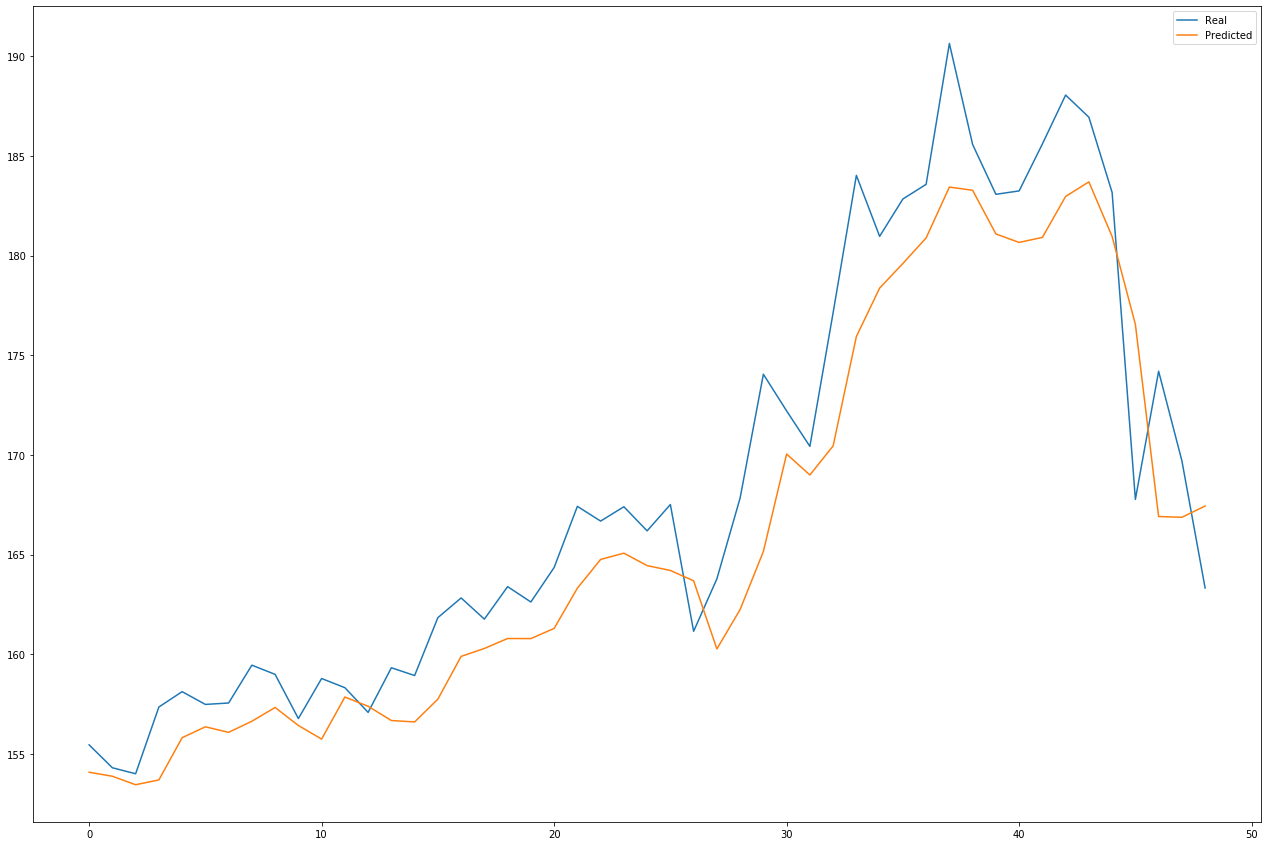

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.gcf().set_size_inches(22, 15, forward=True)

start = -50
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'technical_model.h5')
